In [1]:
import jax
import numpy as np
import numpyro
import numpyro.distributions as dist
import matplotlib.pyplot as plt
import scipy
from numpyro.infer import MCMC, NUTS

from truncated_pareto import TruncatedPareto

In [2]:
scale = 10.0
alpha = 2.0
low = 15.0
high = 100.0

In [3]:
# numpyro
samples_numpyro = TruncatedPareto(scale, alpha, low, high).sample(jax.random.PRNGKey(0), (10000,))

# scipy
samples_scipy = scipy.stats.pareto.rvs(b=2, scale=10, size=10000)
samples_scipy = samples_scipy[(samples_scipy > low) & (samples_scipy < high)]

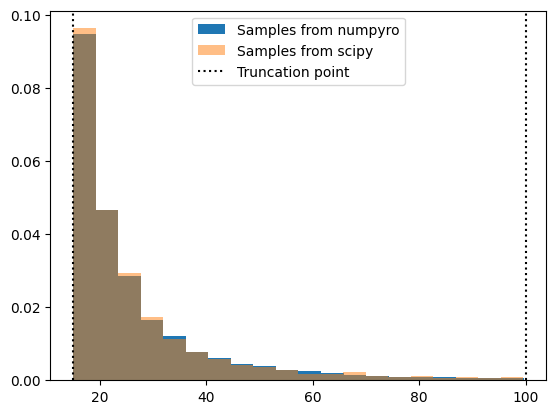

In [4]:
fig, ax = plt.subplots(1, 1)
ax.hist(np.asarray(samples_numpyro), bins=20, density=True, label="Samples from numpyro")
ax.hist(samples_scipy, bins=20, density=True, alpha=0.5, label="Samples from scipy")
ax.axvline(15, linestyle=":", color="k", label="Truncation point")
ax.axvline(100, linestyle=":", color="k")
ax.legend()

In [5]:
def model(num_samples, x=None, min_x=None, max_x=None):
    scale = numpyro.sample("scale", dist.LogNormal())
    alpha = numpyro.sample("alpha", dist.LogNormal())
    low = numpyro.sample("low", dist.TruncatedDistribution(dist.Cauchy(), low=0, high=min_x))
    high = numpyro.sample("high", dist.TruncatedDistribution(dist.Cauchy(), low=max_x))
    with numpyro.plate("observations", num_samples):
        numpyro.sample("x", TruncatedPareto(scale, alpha, low, high), obs=x)

inputs = dict(num_samples=len(samples_scipy), x=samples_scipy, min_x=np.min(samples_scipy), max_x=np.max(samples_scipy))

kernel = NUTS(model)
mcmc = MCMC(kernel, num_samples=1000, num_warmup=500, num_chains=1)
mcmc.run(jax.random.PRNGKey(0), **inputs)
mcmc.print_summary()

sample: 100%|██████████| 1500/1500 [00:01<00:00, 772.30it/s, 7 steps of size 4.13e-01. acc. prob=0.93]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      2.12      0.03      2.12      2.06      2.17    556.78      1.00
      high    100.77      1.23    100.44     99.57    102.37    847.73      1.00
       low     15.00      0.00     15.00     15.00     15.00    715.23      1.00
     scale     10.83      0.08     10.84     10.72     10.96    503.15      1.00

Number of divergences: 0


In [6]:
# multivariate

scale = np.array([10.0, 15, 20])
alpha = np.array([2.0] * 3)
low = np.array([15.0, 20, 40])
high = np.array([100.0])

x = TruncatedPareto(scale, alpha, low, high).sample(jax.random.PRNGKey(0), (500,))

def model(x):
    num_samples, num_dims = x.shape
    min_x = jax.numpy.min(x)
    max_x = jax.numpy.max(x)

    scale = numpyro.sample("scale", dist.LogNormal().expand([num_dims]))
    alpha = numpyro.sample("alpha", dist.LogNormal().expand([num_dims]))
    low = numpyro.sample("low", dist.TruncatedDistribution(dist.Cauchy(), low=0, high=min_x).expand([num_dims]))
    high = numpyro.sample("high", dist.TruncatedDistribution(dist.Cauchy(), low=max_x).expand([num_dims]))
    with numpyro.plate("observations", num_samples):
        numpyro.sample("x", TruncatedPareto(scale, alpha, low, high).to_event(1), obs=x)

x = np.asarray(x)

kernel = NUTS(model)
mcmc = MCMC(kernel, num_samples=1000, num_warmup=500, num_chains=1)
mcmc.run(jax.random.PRNGKey(0), x=x)
mcmc.print_summary()

sample: 100%|██████████| 1500/1500 [00:01<00:00, 774.17it/s, 15 steps of size 3.56e-01. acc. prob=0.92] 


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  alpha[0]      1.96      0.10      1.96      1.81      2.13    670.95      1.00
  alpha[1]      1.18      0.06      1.18      1.08      1.29    735.25      1.00
  alpha[2]      0.57      0.03      0.57      0.51      0.62    687.17      1.00
   high[0]    137.29    397.23    106.35     99.35    131.72    675.21      1.00
   high[1]    102.48      3.25    101.43     99.35    106.90   1460.94      1.00
   high[2]    100.88      1.60    100.40     99.35    102.70   1007.52      1.00
    low[0]     14.99      0.02     15.00     14.97     15.01   1040.51      1.00
    low[1]     14.98      0.02     14.99     14.95     15.01   1324.53      1.00
    low[2]     14.97      0.04     14.98     14.91     15.01   1308.64      1.00
  scale[0]     10.53      0.24     10.53     10.13     10.90    739.62      1.00
  scale[1]      8.50      0.32      8.51      7.97      9.02    774.19      1.00
  scale[2]      5.21      0